# 2A.ml - Interprétabilité et corrélations des variables

Plus un modèle de machine learning contient de coefficients, moins sa décision peut être interprétée. Comment contourner cet obstacle et comprendre ce que le modèle a appris ? Notion de [feature importance](http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html).

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [2]:
# Répare une incompatibilité entre scipy 1.0 et statsmodels 0.8.
from pymyinstall.fix import fix_scipy10_for_statsmodels08
fix_scipy10_for_statsmodels08()

## Modèles linéaires

Les modèles linéaires sont les modèles les plus simples à interpréter. A performance équivalente, il faut toujours choisir le modèle le plus simple. Le module [scikit-learn](http://scikit-learn.org/) ne propose pas les outils standards d'analyse des modèles linéaires (test de nullité, valeur propre). Il faut choisir [statsmodels](http://statsmodels.sourceforge.net/) pour obtenir ces informations.

In [3]:
import numpy
import statsmodels.api as smapi
nsample = 100
x = numpy.linspace(0, 10, 100)
X = numpy.column_stack((x, x**2 - x))
beta = numpy.array([1, 0.1, 10])
e = numpy.random.normal(size=nsample)
X = smapi.add_constant(X)
y = X @ beta + e

In [4]:
model = smapi.OLS(y, X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 4.002e+06
Date:                Sat, 25 Aug 2018   Prob (F-statistic):          3.54e-239
Time:                        17:18:49   Log-Likelihood:                -137.02
No. Observations:                 100   AIC:                             280.0
Df Residuals:                      97   BIC:                             287.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8264      0.284      2.906      0.005       0.262       1.391
x1             0.1508      0.119      1.265      0.209      -0.086       0.387
x2             9.9982      0.013    786.054      0.000       9.973      10.023
==============================================================================
Omnibus:                        0.492   Durbin-Watson:                   1.968
Prob(Omnibus):                  0.782   Jarque-Bera (JB):                0.630
Skew:                           0.046   Prob(JB):                        0.730
Kurtosis:                       2.622   Cond. No.                         125.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Arbres (tree)

### Lectures

* [treeinterpreter](https://github.com/andosa/treeinterpreter)
* [Making Tree Ensembles Interpretable](https://arxiv.org/pdf/1606.05390v1.pdf) : l'article propose de simplifier une random forest en approximant sa sortie par une somme pondérée d'arbre plus simples.
* [Understanding variable importances in forests of randomized trees](http://papers.nips.cc/paper/4928-understanding-variable-importances-in-forests-of-randomized-trees.pdf) : cet article explique plus formellement le calcul des termes ``feature_importances_`` calculés par scikit-learn pour chaque arbre et forêts d'arbres (voir aussi [Random Forests, Leo Breiman and Adele Cutler](http://www.stat.berkeley.edu/~breiman/RandomForests/cc_home.htm))

### Module treeinterpreter

In [5]:
from sklearn.datasets import load_iris
iris = load_iris()
X = iris.data
Y = iris.target

In [6]:
from sklearn.tree import DecisionTreeClassifier
clf2 = DecisionTreeClassifier(max_depth=3)
clf2.fit(X, Y)
Yp2 = clf2.predict(X)

In [7]:
from sklearn.tree import export_graphviz
export_graphviz(clf2, out_file="arbre.dot")

In [8]:
import os
cwd = os.getcwd()
from pyquickhelper.helpgen import find_graphviz_dot
dot = find_graphviz_dot()
os.system ("\"{1}\" -Tpng {0}\\arbre.dot -o {0}\\arbre.png".format(cwd, dot))

0

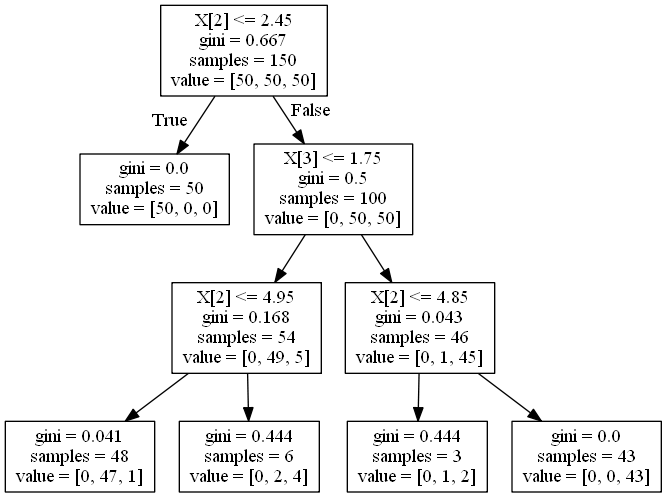

In [9]:
from IPython.display import Image
Image("arbre.png")

In [10]:
from treeinterpreter import treeinterpreter
pred, bias, contrib = treeinterpreter.predict(clf2, X[106:107,:])

c:\python370_x64\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [11]:
X[106:107,:]

array([[4.9, 2.5, 4.5, 1.7]])

In [12]:
pred

array([[0.        , 0.97916667, 0.02083333]])

In [13]:
bias

array([[0.33333333, 0.33333333, 0.33333333]])

In [14]:
contrib

array([[[ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ],
        [-0.33333333,  0.23842593,  0.09490741],
        [ 0.        ,  0.40740741, -0.40740741]]])

``pred`` est identique à ce que retourne la méthode ``predict`` de scikit-learn. ``bias`` est la proportion de chaque classe. ``contrib`` est la somme des contributions de chaque variable à chaque classe. On note $X=(x_1, ..., x_n)$ une observation.

$$P(X \in classe(i)) = \sum_i contrib(x_k,i)$$

Le [code](https://github.com/andosa/treeinterpreter/blob/master/treeinterpreter/treeinterpreter.py) est assez facile à lire et permet de comprendre ce que vaut la fonction $contrib$.

### Exercice 1 : décrire la fonction contrib

La lecture de [Understanding variable importances
in forests of randomized trees](http://papers.nips.cc/paper/4928-understanding-variable-importances-in-forests-of-randomized-trees.pdf) devrait vous y aider.

In [15]:
clf2.feature_importances_

array([0.        , 0.        , 0.58561555, 0.41438445])

### Exercice 2 : implémenter l'algorithme

Décrit dans [Making Tree Ensembles Interpretable](https://arxiv.org/pdf/1606.05390v1.pdf)

## Interprétation et corrélation

### Modèles linéaires

Les modèles linéaires n'aiment pas les variables corrélées. Dans l'exemple qui suit, les variables $X_2, X_3$ sont identiques. La régression ne peut retrouver les coefficients du modèle initial (2 et 8).

In [17]:
import numpy
import statsmodels.api as smapi
nsample = 100
x = numpy.linspace(0, 10, 100)
X = numpy.column_stack((x, (x-5)**2, (x-5)**2))  # ajout de la même variable
beta = numpy.array([1, 0.1, 2, 8])
e = numpy.random.normal(size=nsample)
X = smapi.add_constant(X)
y = X @ beta + e

In [18]:
import pandas
pandas.DataFrame(numpy.corrcoef(X.T))

c:\python370_x64\lib\site-packages\numpy\lib\function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\python370_x64\lib\site-packages\numpy\lib\function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


,0,1,2,3
0,NaN,NaN,NaN,NaN
1,NaN,1.000000e+00,-4.166739e-17,-4.166739e-17
2,NaN,-4.166739e-17,1.000000e+00,1.000000e+00
3,NaN,-4.166739e-17,1.000000e+00,1.000000e+00


In [19]:
model = smapi.OLS(y, X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.786e+05
Date:                Sat, 25 Aug 2018   Prob (F-statistic):          4.67e-183
Time:                        17:18:51   Log-Likelihood:                -142.22
No. Observations:                 100   AIC:                             290.4
Df Residuals:                      97   BIC:                             298.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9061      0.232      3.904      0.000       0.446       1.367
x1             0.1148      0.035      3.285      0.001       0.045       0.184
x2             5.0009      0.007    746.515      0.000       4.988       5.014
x3             5.0009      0.007    746.515      0.000       4.988       5.014
==============================================================================
Omnibus:                        0.790   Durbin-Watson:                   2.259
Prob(Omnibus):                  0.674   Jarque-Bera (JB):                0.756
Skew:                          -0.206   Prob(JB):                        0.685
Kurtosis:                       2.890   Cond. No.                     4.06e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.67e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

### Arbre / tree

Les arbres de décision n'aiment pas plus les variables corrélées.

In [20]:
from sklearn.datasets import load_iris
iris = load_iris()
X = iris.data[:,:2]
Y = iris.target

In [21]:
from sklearn.tree import DecisionTreeClassifier
clf1 = DecisionTreeClassifier(max_depth=3)
clf1.fit(X, Y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [22]:
clf1.feature_importances_

array([0.76759205, 0.23240795])

On recopie la variables $X_1$.

In [23]:
import numpy
X2 = numpy.hstack([X, numpy.ones((X.shape[0], 1))])
X2[:,2] = X2[:,0]

In [24]:
clf2 = DecisionTreeClassifier(max_depth=3)
clf2.fit(X2, Y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [25]:
clf2.feature_importances_

array([0.21510471, 0.23240795, 0.55248735])

On voit que l'importance de la variable 1 est diluée sur deux variables.

### Exercice 3 : variables corrélées pour un arbre de décision

Un arbre de décision est composé d'un ensemble de fonctions de seuil. Si $X_i > s_i$ alors il faut suivre cette branche, sinon, telle autre. Les arbres de décision ne sont pas sensibles aux problèmes d'échelle de variables. Si deux variables sont corrélées $cor(X_1, X_2)= 1$, l'arbre subit les mêmes problèmes qu'un modèle linéaire. Dans le cas linéaire, il suffit de changer l'échelle $(X_1, \ln X_2)$ pour éviter ce problème. 

* Pourquoi cette transformation ne change rien pour un arbre de décision ?
* Quelle corrélation il faudrait calculer pour repérer les variables identiques selon le point de vue d'un arbre de décision ?